In this notebook I will be expanding on what I did in the other file and creating a sentiment analysis model for 5 different classes of sentiment 0,1,2,3, and 4, with 0 being most negative and 4 being most positive. I will be roughly following the code from this link https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data. 

In [17]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
import keras
warnings.filterwarnings('ignore', category=UserWarning, module='bs4')

In [10]:
test = pd.read_csv('C:/Users/benma/bi2/sentiment-analysis-on-movie-reviews/test.tsv.zip', sep='\t')
train = pd.read_csv('C:/Users/benma/bi2/c', sep='\t')
train.shape, test.shape

((156060, 4), (66292, 3))

In [11]:
def show_info(data, is_matrix_transpose=False):
    # basic shape
    print('data shape is: {}   sample number {}   attribute number {}\n'.format(data.shape, data.shape[0], data.shape[1]))
    # attribute(key)
    print('data columns number {}  \nall columns: {}\n'.format(len(data.columns) ,data.columns))
    # value's null
    print('data all attribute count null:\n', data.isna().sum())
    # data value analysis and data demo
    if is_matrix_transpose:
        print('data value analysis: ', data.describe().T)
        print('data demo without matrix transpose: ', data.head().T)
    else:
        print('data value analysis: ', data.describe())
        print('data demo without matrix transpose: ', data.head())

show_info(train)
show_info(test)

data shape is: (156060, 4)   sample number 156060   attribute number 4

data columns number 4  
all columns: Index(['PhraseId', 'SentenceId', 'Phrase', 'Sentiment'], dtype='object')

data all attribute count null:
 PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64
data value analysis:              PhraseId     SentenceId      Sentiment
count  156060.000000  156060.000000  156060.000000
mean    78030.500000    4079.732744       2.063578
std     45050.785842    2502.764394       0.893832
min         1.000000       1.000000       0.000000
25%     39015.750000    1861.750000       2.000000
50%     78030.500000    4017.000000       2.000000
75%    117045.250000    6244.000000       3.000000
max    156060.000000    8544.000000       4.000000
data demo without matrix transpose:     PhraseId  SentenceId                                             Phrase  \
0         1           1  A series of escapades demonstrating the adage ...   
1         2           1  A series 

In [12]:
from bs4 import BeautifulSoup
import re
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import nltk

In [13]:
def data_preprocessing(df):
    reviews = []
    for raw in tqdm(df['Phrase']):
        text = BeautifulSoup(raw, 'lxml').get_text()
        # remove non-letters
        letters_only = re.sub('[^a-zA-Z]', ' ', text)
        words = word_tokenize(letters_only.lower())
        stops = set(stopwords.words('english'))
        non_stopwords = [word for word in words if not word in stops]
        lemma_words = [lemmatizer.lemmatize(word) for word in non_stopwords]    
        reviews.append(lemma_words)
    return reviews


%time train_sentences = data_preprocessing(train)
%time test_sentences = data_preprocessing(test)
len(train_sentences), len(test_sentences)

  0%|          | 225/66292 [00:00<00:57, 1154.35it/s]

Wall time: 2min 1s


100%|██████████| 66292/66292 [00:44<00:00, 1503.51it/s]

Wall time: 44.1 s


(156060, 66292)

In [18]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

In [19]:
# extract label columns and to_categorical
target = train.Sentiment.values
y_target = to_categorical(target)
num_classes = y_target.shape[1]

In [20]:
# train set => split to train and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_sentences, y_target, test_size=0.2, stratify=y_target)

In [21]:
# keras tokenzier initialization
unique_words = set()
len_max = 0
for sent in tqdm(X_train):
    unique_words.update(sent)
    if len_max < len(sent):
        len_max = len(sent)
len(list(unique_words)), len_max

100%|██████████| 124848/124848 [00:00<00:00, 881372.06it/s]


(13620, 29)

In [22]:
# transfer to keras tokenizer
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(X_train))

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(test_sentences)

X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_val = sequence.pad_sequences(X_val, maxlen=len_max)
X_test = sequence.pad_sequences(X_test, maxlen=len_max)

X_train.shape, X_val.shape, X_test.shape

((124848, 29), (31212, 29), (66292, 29))

In [23]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.optimizers import Adam

In [24]:
early_stopping = EarlyStopping(min_delta=0.001, mode='max', monitor='val_acc', patience=2)
callback = [early_stopping]

The model will be created with two LSTM layers using the embedded vector of integers representing the reviews

In [25]:
# build model
model = Sequential()
model.add(Embedding(len(list(unique_words)), 300, input_length=len_max))
model.add(LSTM(128, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))
model.add(LSTM(64, dropout=0.5, recurrent_dropout=0.5, return_sequences=False))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.005), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 29, 300)           4086000   
_________________________________________________________________
lstm (LSTM)                  (None, 29, 128)           219648    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 100)               6500      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 4,362,061
Trainable params: 4,362,061
Non-trainable params: 0
______________________________________________

In [26]:
%%time

# fit
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=256, verbose=1, callbacks=callback)

Epoch 1/10
488/488 [==============================] - 143s 286ms/step - loss: 1.1222 - accuracy: 0.5544 - val_loss: 0.8648 - val_accuracy: 0.6503
Epoch 2/10
488/488 [==============================] - 140s 286ms/step - loss: 0.8140 - accuracy: 0.6689 - val_loss: 0.8368 - val_accuracy: 0.6596
Epoch 3/10
488/488 [==============================] - 137s 282ms/step - loss: 0.7371 - accuracy: 0.6957 - val_loss: 0.8307 - val_accuracy: 0.6656
Epoch 4/10
488/488 [==============================] - 147s 302ms/step - loss: 0.6926 - accuracy: 0.7126 - val_loss: 0.8454 - val_accuracy: 0.6608
Epoch 5/10
488/488 [==============================] - 150s 308ms/step - loss: 0.6617 - accuracy: 0.7234 - val_loss: 0.8740 - val_accuracy: 0.6603
Epoch 6/10
488/488 [==============================] - 140s 288ms/step - loss: 0.6411 - accuracy: 0.7296 - val_loss: 0.8771 - val_accuracy: 0.6601
Epoch 7/10
488/488 [==============================] - 138s 283ms/step - loss: 0.6305 - accuracy: 0.7337 - val_loss: 0.9210 -

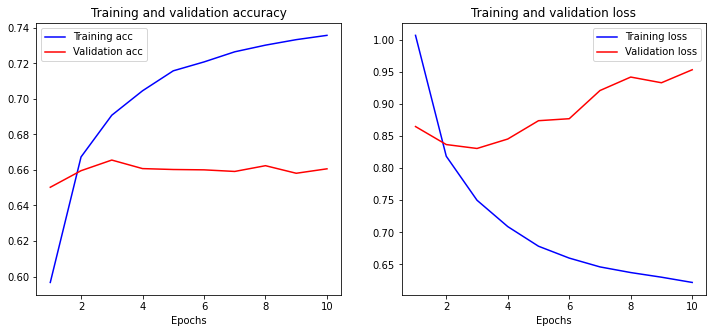

In [260]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel("Epochs")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.xlabel("Epochs")

    plt.title('Training and validation loss')
    plt.legend()
    
plot_history(history)

Looking at the above output with, specifically the accuracy and validation accuracy, I am suprised at how well the model did. Considering that there are 5 classes, a validation accuracy of about 2/3 seems to be pretty good to me. The plots above do show however that the validation accuracy does not seem to be improving with more epochs which is a little disappointing but all in all Id say that I am happy with how the model turned out. 

In [27]:
y_pred = model.predict_classes(X_test)
submission = pd.read_csv('C:/Users/benma/bi2/sentiment-analysis-on-movie-reviews/sampleSubmission.csv')
submission.Sentiment = y_pred
submission.to_csv('submission.csv', index=False)

C:\Users\benma\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [124]:
arr = [len(df["Phrase"][i].split()) for i in range(0,len(df["Phrase"]))]
sentiment_phrase = {"Sentiment": submission["Sentiment"], "Phrase": test["Phrase"], "N-gram": arr}
df = pd.DataFrame(data = sentiment_phrase)

In [125]:
df

,Sentiment,Phrase,N-gram
0,2,An intermittently pleasing but mostly routine ...,8
1,2,An intermittently pleasing but mostly routine ...,7
2,2,An,1
3,2,intermittently pleasing but mostly routine effort,6
4,3,intermittently pleasing but mostly routine,5
...,...,...,...
66287,1,"A long-winded , predictable scenario .",6
66288,1,"A long-winded , predictable scenario",5
66289,1,"A long-winded ,",3
66290,1,A long-winded,2


In [177]:
# sent0 = [sum(np.logical_and(df["N-gram"] == i, df["Sentiment"] == 1)) for i in range(0,40)]
sent0 = [df[(df["Sentiment"] == 0) & (df["N-gram"] ==i)].count()["Sentiment"] for i in range(0,50)]
sent1 = [df[(df["Sentiment"] == 1) & (df["N-gram"] ==i)].count()["Sentiment"] for i in range(0,50)]
sent2 = [df[(df["Sentiment"] == 2) & (df["N-gram"] ==i)].count()["Sentiment"] for i in range(0,50)]
sent3 = [df[(df["Sentiment"] == 3) & (df["N-gram"] ==i)].count()["Sentiment"] for i in range(0,50)]
sent4 = [df[(df["Sentiment"] == 4) & (df["N-gram"] ==i)].count()["Sentiment"] for i in range(0,50)]

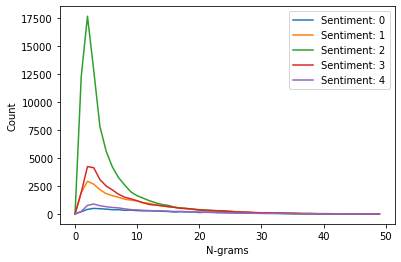

In [252]:
fig = plt.figure()
ax = plt.axes()

x = [i for i in range(0,50)]
ax.plot(x, sent0, label = "Sentiment: 0");
ax.plot(x, sent1, label = "Sentiment: 1");
ax.plot(x, sent2, label = "Sentiment: 2");
ax.plot(x, sent3, label = "Sentiment: 3");
ax.plot(x, sent4, label = "Sentiment: 4");
ax.set_xlabel("N-grams")
ax.set_ylabel("Count")

ax.legend()

The plot above shows the distribution for the sentiments with the x-axis being the n-gram length and the y-axis being the number of reveiws at that n-gram value for the sentiments. This is not a super useful plot so I will standardized the values by looking at the frequencies at which the sentiments occur.

In [208]:
x = [i for i in range(0,50)]
sum = [sent0[i]+sent1[i]+sent2[i]+sent3[i]+sent4[i] for i in range(0,50)]
freq0 = [sent0[i]/(sum[i]) for i in range(0,50)]
freq1 = [sent1[i]/(sum[i]) for i in range(0,50)]
freq2 = [sent2[i]/(sum[i]) for i in range(0,50)]
freq3 = [sent3[i]/(sum[i]) for i in range(0,50)]
freq4 = [sent4[i]/(sum[i]) for i in range(0,50)]

Text(0, 0.5, 'Frequencies')

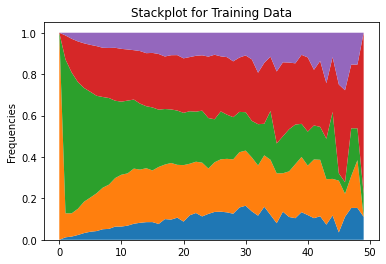

In [256]:
plt.stackplot(x, freq0,freq1,freq2,freq3,freq4)
plt.title("Stackplot for Training Data")
plt.ylabel("Frequencies")

The above stackplot displays the frequency of classification of each class of sentiment for the n-grams from 0 to 50. There are more large spikes and dips than what I had expected.

In [178]:
y_pred = model.predict_classes(X_train)
submission=y_pred
submission

C:\Users\benma\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([1, 3, 1, ..., 4, 4, 2], dtype=int64)

In [184]:
nGram = [len(train["Phrase"][i].split()) for i in range(0,len(train["Phrase"]))]
train["N-gram"] = nGram

In [185]:
sent0 = [train[(train["Sentiment"] == 0) & (train["N-gram"] ==i)].count()["Sentiment"] for i in range(0,50)]
sent1 = [train[(train["Sentiment"] == 1) & (train["N-gram"] ==i)].count()["Sentiment"] for i in range(0,50)]
sent2 = [train[(train["Sentiment"] == 2) & (train["N-gram"] ==i)].count()["Sentiment"] for i in range(0,50)]
sent3 = [train[(train["Sentiment"] == 3) & (train["N-gram"] ==i)].count()["Sentiment"] for i in range(0,50)]
sent4 = [train[(train["Sentiment"] == 4) & (train["N-gram"] ==i)].count()["Sentiment"] for i in range(0,50)]


In [186]:
x = [i for i in range(0,50)]
sum = [sent0[i]+sent1[i]+sent2[i]+sent3[i]+sent4[i] for i in range(0,50)]
freq0 = [sent0[i]/(sum[i]) for i in range(0,50)]
freq1 = [sent1[i]/(sum[i]) for i in range(0,50)]
freq2 = [sent2[i]/(sum[i]) for i in range(0,50)]
freq3 = [sent3[i]/(sum[i]) for i in range(0,50)]
freq4 = [sent4[i]/(sum[i]) for i in range(0,50)]

Text(0, 0.5, 'Frequencies')

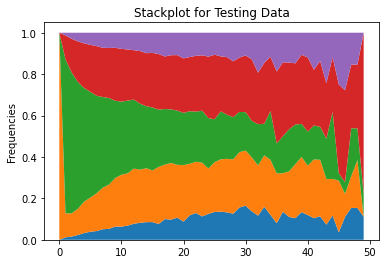

In [255]:
plt.stackplot(x, freq0,freq1,freq2,freq3,freq4)
plt.title("Stackplot for Training Data")
plt.ylabel("Frequencies")

The above stackplot shows the distribution of how frequent each sentiment is occuring for every n-gram from 0 to 50. As you can see, the frequencies for small n-grams, 0-5, and large one, 40-50, seems too be incredibly volatile while the center values seem to be much more consistent. It is also interesting to see how for a 0-gram it is automatically classified as a 1. This can be thrown out since a 0-gram does not really hold any material meaning. Additionally, this stackplot is less volatile than the previous one, I am assuming this is caused by the fact that this is the training data rather than the testing data. Thus, since the model was tested on this, it is likely to have smoothed the large spikes and dips.

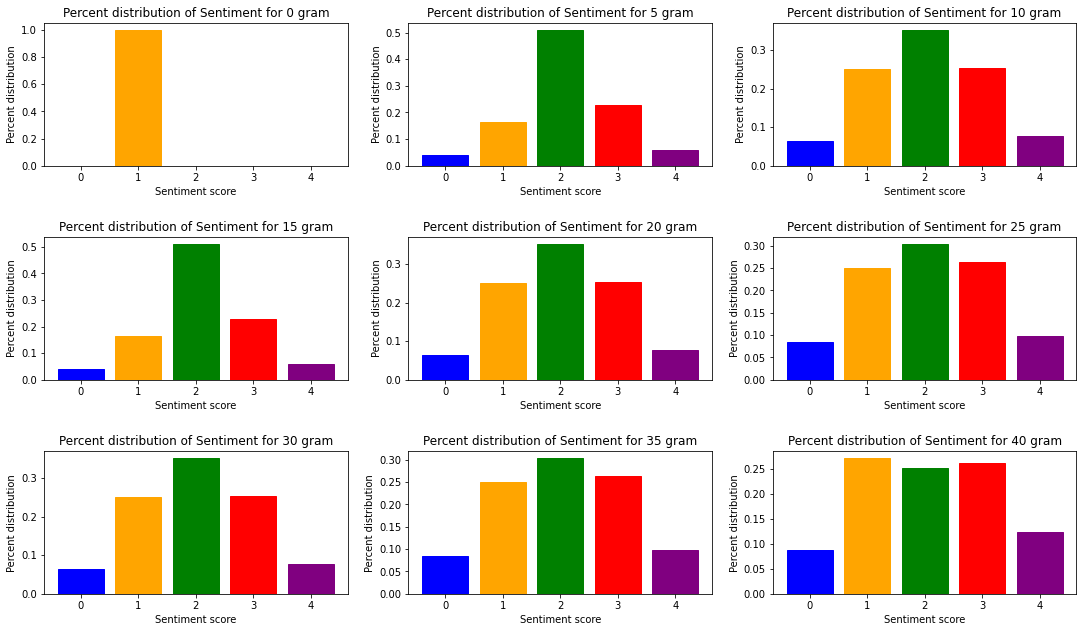

In [245]:
fig, ax = plt.subplots(nrows = 3, ncols = 3)
fig.set_size_inches(18.5, 10.5)
fig.subplots_adjust(hspace=.5)
for ind,row in enumerate(ax):
    for ind2,col in enumerate(row):
        ngram = 5*(3*ind+ind2)
        bar = col.bar([0,1,2,3,4],[freq0[5*(ind+ind2)],freq1[5*(ind+ind2)],freq2[5*(ind+ind2)],freq3[5*(ind+ind2)],freq4[5*(ind+ind2)]])
        bar[0].set_color("b")
        bar[1].set_color("orange")
        bar[2].set_color("green")
        bar[3].set_color("red")
        bar[4].set_color("purple")
        
        col.set_title("Percent distribution of Sentiment for {} gram".format(ngram))
        col.set_ylabel("Percent distribution")
        col.set_xlabel("Sentiment score")
        
plt.show()


The plots above are frequency histograms of the sentiment scores for every n-gram that is a multiple of 5. Interestingly, the model assings a score of 1 to an n-gram of 0. Also, the plots are mostly normally distributed it seems like. It is obviously hard to know for sure because there are only 5 values for which the scores can be. 

## Final Thoughts
This was really interesting for me to see a more complicated classification of the sentiment of the movie reviews. I was impressed at how well the model did but I am curious to see if I could have made it better with more hyperparameter tuning.